In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [110]:
df = pd.read_csv('images/fit19_new.csv', index_col=0)
df_lum = pd.read_csv('/storeA/ryzhenenkov/lum2019.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
df_triggers = pd.read_csv('images/triggers19_new.csv', index_col=0)
df = df.join(df_lum).join(df_triggers[['eff_trig', 'eff_trig_err']])
df['n0_mc'] = 20000

In [113]:
df.head()

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,aL_mc_err,aR_mc_err,emeas,lum,lum_err,eff_trig,eff_trig_err,n0_mc,eff_reg,eff_reg_err
537.5,2178.978308,4.103284e-08,0.020957,3.035526,2.684457,0.088348,0.147776,0.000014,32.874884,5.738491,...,0.002585,0.005571,537.480652,1224.66,1.75856,0.996333,0.000715,20000,0.113708,0.001686
550.0,1524.769472,5.236851e+00,0.347903,3.390592,2.788483,0.082753,0.160511,9.590926,34.786473,15.294194,...,0.002851,0.006378,549.340454,1424.27,1.93920,0.996937,0.000774,20000,0.105098,0.001616
562.5,723.817921,8.141569e+00,0.491515,3.345036,2.506786,0.081618,0.151051,0.070368,22.669801,9.028397,...,0.002979,0.005283,562.499817,1048.68,1.70440,0.994255,0.001678,20000,0.100550,0.001585
575.0,573.013736,6.496837e-07,0.252027,2.983930,2.474596,0.079659,0.151603,3.486498,15.933425,1.799810,...,0.002805,0.005269,574.862061,1054.35,1.74597,0.995127,0.001219,20000,0.093699,0.001531
587.5,401.965750,2.603856e+01,0.252074,3.093266,2.182504,0.084589,0.150150,0.083068,21.119477,16.088450,...,0.002888,0.005211,587.732422,1167.38,1.87792,0.996413,0.001059,20000,0.088900,0.001491


In [114]:
df['eff_reg'], df['eff_reg_err'] = df['n_sig_mc']/df['n0_mc'], df['n_sig_mc_err']/df['n0_mc']

In [115]:
df['cs_vis'] = df['n_sig_exp']/(df['eff_reg']*df['eff_trig']*df['lum'])

In [116]:
df_koz = pd.read_csv('images/kozyrev.txt')
df_koz['emeas'] = df_koz['E']/2
df_koz['cs_vis'] = df_koz['cs']*df_koz['rad']

In [117]:
df_vis = pd.concat([df_koz[['emeas', 'cs_vis']], df[['emeas', 'cs_vis']]], ignore_index=True).sort_values(by='emeas')
df_vis['rad'] = 1
df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [118]:
df_vis.head()

,emeas,cs_vis,rad,cs_born
0,502.0330,4.9464,1,4.9464
1,505.2330,30.7768,1,30.7768
2,506.4775,69.6528,1,69.6528
3,507.5340,155.8663,1,155.8663
4,508.0525,260.0943,1,260.0943


In [119]:
df_approx = pd.read_csv('../data/cross_sections_kskl.txt', sep=' ', index_col=0, names=['E', 'cs_born'])
df_approx['emeas'] = df_approx['E']/2
df_approx['rad'] = 1

In [120]:
from scipy.interpolate import make_interp_spline

In [121]:
df_approx

,E,cs_born,emeas,rad
2,995.0,0.000000,497.5,1
3,996.0,0.067593,498.0,1
4,997.0,0.292279,498.5,1
5,998.0,0.642567,499.0,1
6,999.0,1.128050,499.5,1
...,...,...,...,...
545,2092.0,0.368000,1046.0,1
546,2094.0,0.381000,1047.0,1
547,2096.0,0.394000,1048.0,1
548,2098.0,0.409000,1049.0,1


In [122]:
from pylib.radcors import RadCor

1	

/spoolA/petrov/refac20/notebooks/pylib/radcors.py:66: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  0., Xmax, points=[0, 1], limit=50000, epsrel=0.0001)


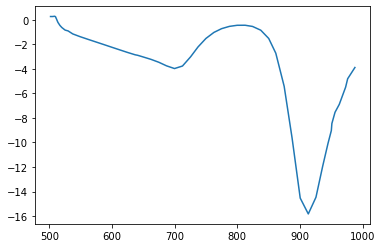

In [123]:
n_iter = 1
for _ in range(n_iter):
    print(_+1, end='\t')
    spl = make_interp_spline(df_approx.emeas, df_approx.cs_born, k=1)
    e_interp = np.linspace(495, 1000, 3000) 
    cs_interp = spl(e_interp)
    cs_interp = np.where(e_interp<497.6, 0, cs_interp)
    cs_interp = np.where(cs_interp<0, 0, cs_interp)

    r = RadCor(e_interp, cs_interp)

    temp_rads = df_vis.rad.copy().astype('float')
    for i, j in df_vis.iterrows():
        temp_rads[i] = r.F_Radcor(j['emeas'])[0]
    if (_==(n_iter-1)):
        plt.plot(df_vis['emeas'], df_vis['rad']-temp_rads)
    
    df_vis['rad'] = temp_rads
    df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [124]:
df_vis.tail(5)

,emeas,cs_vis,rad,cs_born
58,956.036438,0.127233,8.537467,0.014903
59,962.821045,0.367852,7.892775,0.046606
60,972.950867,0.381593,6.488969,0.058806
61,976.210022,0.332246,5.803554,0.057249
62,987.769592,0.250554,4.885168,0.051289


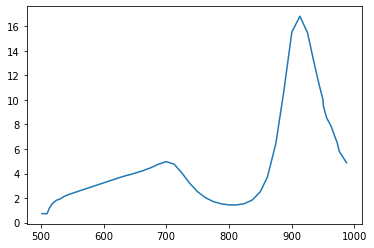

In [125]:
plt.plot(df_vis.emeas, df_vis.rad)

In [126]:
df_n = df.merge(df_vis[['emeas', 'rad']], on='emeas')

In [127]:
df_n['cs_born'] = df_n['cs_vis']/df_n['rad']

In [128]:
df_n.tail()

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,lum,lum_err,eff_trig,eff_trig_err,n0_mc,eff_reg,eff_reg_err,cs_vis,rad,cs_born
37,32.428316,67.586926,1.388407,2.866742,1.611160,0.087179,0.149888,4.095325e-02,6.434838,7.677412,...,2272.430,4.35670,0.988800,0.006543,20000,0.057600,0.001192,0.250554,4.885168,0.051289
38,115.328843,2.671179,0.124264,2.379524,2.602095,0.079620,0.169035,1.785239e-12,7.884957,2.351458,...,954.102,1.87173,0.997253,0.001603,20000,0.067404,0.001298,1.798257,4.027405,0.446505
39,135.257916,13.742119,0.352305,2.699567,2.418510,0.084251,0.109204,8.396457e-03,9.493643,5.428159,...,989.271,2.26543,0.997651,0.001323,20000,0.145799,0.001909,0.939971,1.718608,0.546938
40,127.517038,42.483028,0.205863,2.133130,2.117789,0.080264,0.148957,7.187264e-01,10.096716,7.695082,...,1067.520,2.54467,0.998327,0.000912,20000,0.173545,0.002083,0.689459,1.843930,0.373908
41,23.617363,37.382644,-0.058447,2.425794,1.330691,0.064259,0.245803,1.159932e-01,5.667674,6.245360,...,1019.520,2.59089,0.994721,0.003974,20000,0.064298,0.001268,0.362190,6.420424,0.056412


In [134]:
# df_n.to_csv('images/res19_new.csv')

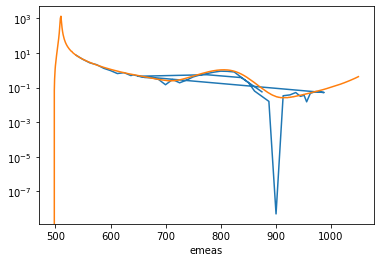

In [130]:
df_n.set_index('emeas').cs_born.plot()
plt.plot(df_approx.emeas, df_approx.cs_born)
plt.yscale('log')

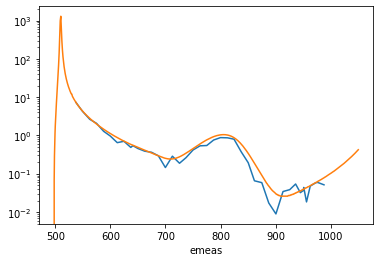

In [64]:
df_n.set_index('emeas').cs_born.plot()
plt.plot(df_approx.emeas, df_approx.cs_born)
plt.yscale('log')

Сечение

In [135]:
dfs = [pd.read_csv('images/res11_new.csv', index_col=0),
      pd.read_csv('images/res19_new.csv', index_col=0)]

In [136]:
for df in dfs:
    if 'n_sig_exp' not in df.columns:
        df['n_sig'] = df['n_exp']*df['f_exp']
        df['n_sig_err'] = df['n_sig']*np.sqrt( (df['n_exp_err']/df['n_exp'])**2 + (df['f_exp_err']/df['f_exp'])**2 )
    else:
        df['n_sig'] = df['n_sig_exp']
        df['n_sig_err'] = df['n_sig_exp_err']
    df['cs_born_err'] = df['cs_born']*np.sqrt( (df['n_sig_err']/df['n_sig'])**2 + (df['eff_reg_err']/df['eff_reg'])**2 +\
                                             (df['eff_trig_err']/df['eff_trig'])**2)

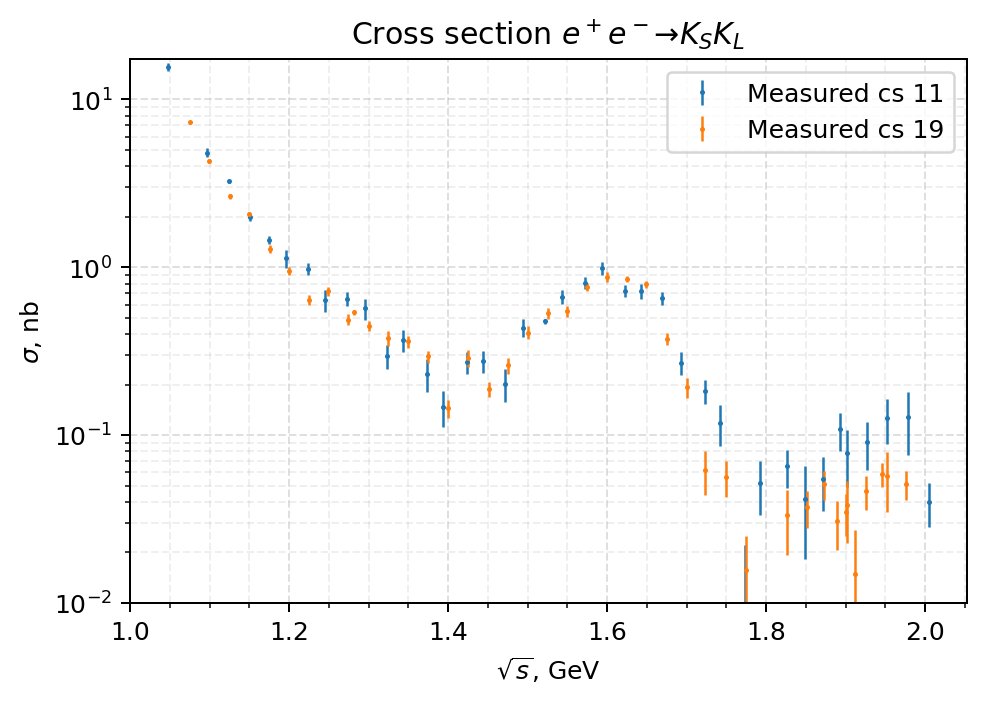

In [141]:
plt.figure(dpi=180)
for df, e in zip(dfs, ['11', '19']):
    plt.errorbar(df.emeas*2e-3, df.cs_born, yerr=df.cs_born_err, fmt='.', label=f'Measured cs {e}', alpha=1, markersize=2, lw=1)
# plt.plot(df_approx.emeas*2e-3, df_approx.cs_born, label='Cross section in MC')
# plt.errorbar(df_koz.E, df_koz.cs, yerr=df_koz.cs_err, fmt='.')
# plt.xlim(520*2, 1200)
plt.grid(ls='--', alpha=0.4)
plt.grid(which='minor', ls='--', alpha=0.2)
plt.minorticks_on()
plt.legend()
plt.ylim(1e-2, None)
plt.yscale('log')
plt.title('Cross section $e^+ e^- \\to K_S K_L$')
plt.ylabel('$\sigma$, nb')
plt.xlabel('$\sqrt{s}$, GeV');
# plt.savefig('images/cs_kskl1.png', dpi=120)

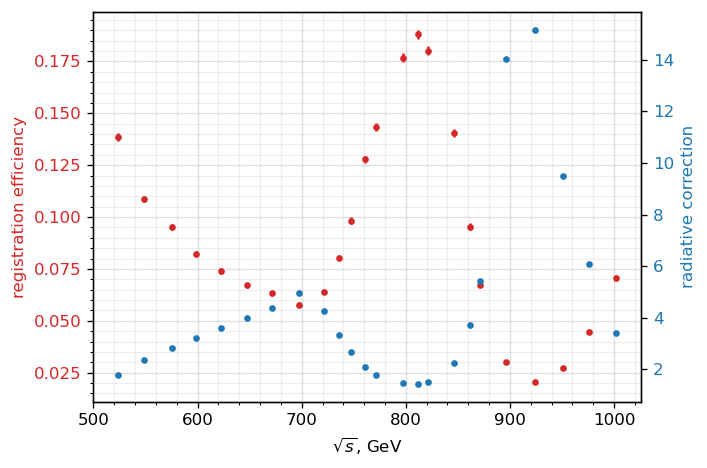

In [27]:
fig, ax1 = plt.subplots(dpi=120)

color = 'tab:red'
ax1.set_xlabel('$\sqrt{s}$, GeV')
ax1.set_ylabel('registration efficiency', color=color)
ax1.errorbar(df.emeas, df.eff_reg, yerr=df.eff_reg_err, fmt='.', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('radiative correction', color=color)  # we already handled the x-label with ax1
ax2.scatter(df.emeas, df.rad, marker='.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid(alpha=0.4)
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('images/rad_reg_eff.png', dpi=120)